In [187]:
import numpy as np
import polars as pl
import seaborn as sns
import cv2

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass, shift
import random

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import torchvision
import torchvision.transforms as T
from scipy.ndimage import gaussian_filter, map_coordinates
from sklearn.svm import SVC
from PIL import Image

In [188]:
train_data = pl.read_csv(
    "./data/train.csv", schema={"filename": pl.String, "label": pl.String}
).with_columns(("./data/train/" + pl.col("filename")).alias("filename"))

test_data = pl.read_csv("./data/test.csv").with_columns(
    ("./data/test/" + pl.col("filename")).alias("filename")
)

In [189]:
np.random.seed(42)

# EDA
Firstly, I want to see the distribution of the lables.

In [190]:
train_data.describe()

statistic,filename,label
str,str,str
"""count""","""60000""","""60000"""
"""null_count""","""0""","""0"""
"""mean""",null,null
"""std""",null,null
"""min""","""./data/train/0000a924c12d.png""","""10"""
"""25%""",null,null
"""50%""",null,null
"""75%""",null,null
"""max""","""./data/train/fffed4bad0cf.png""","""99"""


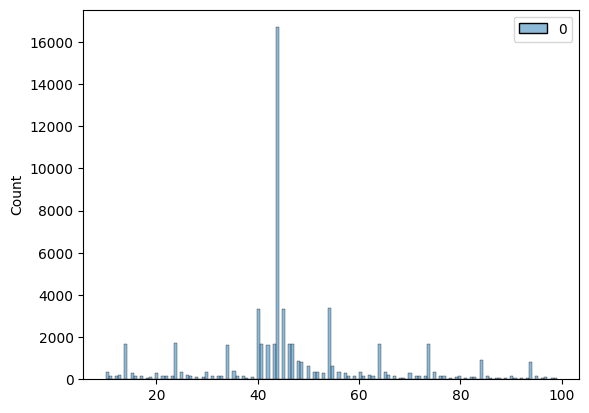

In [191]:
sns.histplot(train_data.select(pl.col("label").cast(pl.Int32)))
plt.show()

Okay, I see that dataset is seriously imabalnced, to number 40 -- 46. I have looked over images in the dataset, and I suppose they are perfectly separable in half. In future I may consider training it on the original MNIST.

Supposing I have split image in 2 parts, I can already embeed it in feature vector and train MLP or SVM on it. But I notices that digits are scattared from top to bottom. In my opinion this may make it harder for model to seperate a space. As it will learn this "spatial" position of a digit as feature. So I further notices that all the digits are almost of the same scale. I will simply trim each image, to fit constant size. But for that I need to analyze "heights" of each seperate image.

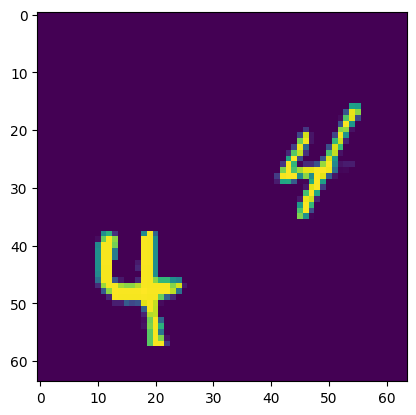

(64, 64)


In [192]:
random_image = cv2.cvtColor(
    cv2.imread(train_data["filename"].sample(n=1)[0]), cv2.COLOR_BGR2GRAY
)
plt.imshow(random_image)
plt.show()

print(random_image.shape)

In [193]:
def get_left_right_parts(image_path: str) -> tuple[np.ndarray, np.ndarray]:
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)
    if image is None:
        raise ValueError("asd")

    w, h = image.shape
    image_left, image_right = image[:, : h // 2], image[:, h // 2 :]

    return image_left, image_right

In [194]:
def find_first_last_pixel(image: np.ndarray) -> list[int]:
    not_black_rows = np.where(np.any(image > 0, axis=1))[0]
    not_black_cols = np.where(np.any(image > 0, axis=0))[0]

    return [
        not_black_rows[0],
        not_black_rows[-1],
        not_black_cols[0],
        not_black_cols[-1],
    ]

In [195]:
def preprocess_data_set(data: pl.DataFrame) -> pl.DataFrame:
    return data.with_columns(
        pl.col("filename")
        .map_elements(
            lambda path_: find_first_last_pixel(get_left_right_parts(path_)[0]),
            return_dtype=pl.List(pl.Int32),
        )
        .alias("LeftDigitBounds"),
        pl.col("filename")
        .map_elements(
            lambda path_: find_first_last_pixel(get_left_right_parts(path_)[-1]),
            return_dtype=pl.List(pl.Int32),
        )
        .alias("RightDigitBounds"),
    ).with_columns(
        (
            pl.col("LeftDigitBounds").list.get(1)
            - pl.col("LeftDigitBounds").list.get(0)
        ).alias("LeftHeight"),
        (
            pl.col("LeftDigitBounds").list.get(3)
            - pl.col("LeftDigitBounds").list.get(2)
        ).alias("LeftWidth"),
        (
            pl.col("RightDigitBounds").list.get(1)
            - pl.col("RightDigitBounds").list.get(0)
        ).alias("RightHeight"),
        (
            pl.col("RightDigitBounds").list.get(3)
            - pl.col("RightDigitBounds").list.get(2)
        ).alias("RightWidth"),
    )


In [196]:
train_data_preprocessed = preprocess_data_set(train_data)

In [197]:
train_data_preprocessed.describe()

statistic,filename,label,LeftDigitBounds,RightDigitBounds,LeftHeight,LeftWidth,RightHeight,RightWidth
str,str,str,f64,f64,f64,f64,f64,f64
"""count""","""60000""","""60000""",60000.0,60000.0,60000.0,60000.0,60000.0,60000.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,null,null,18.760567,15.118883,18.743467,15.3106
"""std""",null,null,null,null,0.941428,3.411355,0.95347,3.363329
"""min""","""./data/train/0000a924c12d.png""","""10""",null,null,8.0,2.0,9.0,1.0
"""25%""",null,null,null,null,19.0,13.0,19.0,13.0
"""50%""",null,null,null,null,19.0,15.0,19.0,15.0
"""75%""",null,null,null,null,19.0,19.0,19.0,19.0
"""max""","""./data/train/fffed4bad0cf.png""","""99""",null,null,19.0,19.0,19.0,19.0


I can see that mostly all digits are 19 pixels in height, which is comfortable for me. Now I will also examine whether it is the case for test dataset.

In [198]:
test_data_preprocessed = preprocess_data_set(test_data)
test_data_preprocessed.describe()

statistic,filename,LeftDigitBounds,RightDigitBounds,LeftHeight,LeftWidth,RightHeight,RightWidth
str,str,f64,f64,f64,f64,f64,f64
"""count""","""20000""",20000.0,20000.0,20000.0,20000.0,20000.0,20000.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,null,18.7816,14.4531,18.7662,14.6256
"""std""",null,null,null,0.934208,3.766445,0.948094,3.719707
"""min""","""./data/test/000158b67254.png""",null,null,9.0,2.0,9.0,2.0
"""25%""",null,null,null,19.0,13.0,19.0,13.0
"""50%""",null,null,null,19.0,15.0,19.0,15.0
"""75%""",null,null,null,19.0,17.0,19.0,18.0
"""max""","""./data/test/fffc66424609.png""",null,null,19.0,19.0,19.0,19.0


Okay, seems to be the same situation. Then, on each image's half, I can find first non-zero row and take 19 more rows, and it will be my image. I wonder whether this low dimensionality can make performace worse in comparion to classical mnist with 784 feature encoding.

# Helping function

Because right parts may have less than 20 pixels in width, pytorch will fail. BTW, I found that MNIST is originaly 20x20, but it was padded to be 28x28 and each digit is centered according to mass center, which makes performance better as model does not have to learn spacial features.

In [199]:
def get_left_right_digit(data: pl.DataFrame, idx: int) -> tuple[np.ndarray, np.ndarray]:
    image_path = data["filename"][idx]
    left_, right_ = get_left_right_parts(image_path)
    left_start = data["LeftDigitBounds"][idx][0]
    right_start = data["RightDigitBounds"][idx][0]

    left_col_start = data["LeftDigitBounds"][idx][2]
    right_col_start = data["RightDigitBounds"][idx][2]

    left_image_trimmed = left_[
        left_start : left_start + 19 + 1,
        left_col_start : left_col_start + 19 + 1,
    ]
    right_image_trimmed = right_[
        right_start : right_start + 19 + 1,
        right_col_start : right_col_start + 19 + 1,
    ]

    return left_image_trimmed, right_image_trimmed

In [200]:
torch_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [201]:
def pad_to_20x20(img: np.ndarray) -> np.ndarray:
    h, w = img.shape
    pad_h = max(0, 20 - h)
    pad_w = max(0, 20 - w)
    return np.pad(img, ((0, pad_h), (0, pad_w)), mode="constant", constant_values=0)

In [202]:
def mnist_preprocess(img: np.ndarray) -> np.ndarray:
    img = img.astype(np.float32) / 255.0

    cy, cx = center_of_mass(img)

    canvas = np.zeros((28, 28), dtype=np.float32)

    top = int(round(14 - cy))
    left = int(round(14 - cx))

    y1 = max(top, 0)
    y2 = min(top + 20, 28)
    x1 = max(left, 0)
    x2 = min(left + 20, 28)

    src_y1 = max(0, -top)
    src_y2 = src_y1 + (y2 - y1)
    src_x1 = max(0, -left)
    src_x2 = src_x1 + (x2 - x1)

    canvas[y1:y2, x1:x2] = img[src_y1:src_y2, src_x1:src_x2]

    return canvas

In [203]:
def elastic_deformation(image, alpha=36.0, sigma=5.0):
    image_np = np.array(image, dtype=np.float32)

    random_state = np.random.RandomState(None)
    shape = image_np.shape

    dx = (
        gaussian_filter(
            (random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0
        )
        * alpha
    )
    dy = (
        gaussian_filter(
            (random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0
        )
        * alpha
    )

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    distorted = map_coordinates(image_np, indices, order=1, mode="reflect").reshape(
        shape
    )
    return Image.fromarray(np.uint8(distorted))


def random_affine(image, label, beta=10.0, gamma=20.0):
    if label in [1, 7]:
        beta = 5.0

    if random.random() < 0.5:
        angle = beta
        shear = 0.0
    else:
        angle = 0.0
        shear = beta

    affine = T.RandomAffine(
        degrees=(-angle, angle),
        shear=(-shear, shear),
        scale=(1 - gamma / 100, 1 + gamma / 100),
        fill=0,
    )
    return affine(image)


def random_augmentation(
    img,
    class_: int,
    alpha_range: tuple[float, float] = (36.0, 38.0),
    sigma_range: tuple[float, float] = (5.0, 6.0),
    beta: float = 10.0,
    gamma_range: tuple[float, float] = (0, 3.0),
):
    alpha = random.uniform(*alpha_range)
    sigma = random.uniform(*sigma_range)
    img = elastic_deformation(img, alpha, sigma)
    gamma = random.uniform(*gamma_range)
    img = random_affine(img, class_, beta, gamma)

    return img


In [241]:
class SplitDigitDataset(Dataset):
    def __init__(
        self,
        data: pl.DataFrame,
        only_unique: bool = True,
        augment_data: bool = False,
        sigma_range: tuple[float, float] = (5.0, 6.0),
        alpha_range: tuple[float, float] = (36.0, 38.0),
        beta: float = 15.0,
        gamma_range: tuple[float, float] = (15.0, 20.0),
        mnist_style: bool = False,
    ):
        self.data = []
        self.labels = []

        self.sigma_range = sigma_range
        self.alpha_range = alpha_range
        self.beta = beta
        self.gamma_range = gamma_range

        for idx in range(len(data)):
            left_digit, right_digit = get_left_right_digit(data, idx)
            left_label, right_label = (
                int(data["label"][idx][0]),
                int(data["label"][idx][1]),
            )
            left_digit = pad_to_20x20(left_digit)
            right_digit = pad_to_20x20(right_digit)

            if mnist_style is True:
                left_digit = mnist_preprocess(left_digit)
                right_digit = mnist_preprocess(right_digit)

            self.data.append(torch_transform(left_digit))
            self.data.append(torch_transform(right_digit))
            self.labels.append(left_label)
            self.labels.append(right_label)

        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
        if only_unique is True:
            flattened = self.data.reshape(len(self.data), -1)

            flattened, idxs = np.unique(flattened, return_index=True, axis=0)

            self.data = flattened.reshape(-1, *self.data.shape[1:])
            self.labels = self.labels[idxs]

        if augment_data:
            class_counts = np.bincount(self.labels)
            for class_ in range(10):
                images_with_class = self.data[self.labels == class_]

                new_images = np.max(class_counts) - class_counts[class_] + 5000
                if new_images == 0:
                    continue

                random_mask = np.zeros(class_counts[class_], dtype=bool)
                random_mask[0] = True

                augmented_images = []
                while len(augmented_images) < new_images:
                    np.random.shuffle(random_mask)
                    img = images_with_class[random_mask]
                    alpha = random.uniform(*self.alpha_range)
                    sigma = random.uniform(*self.sigma_range)
                    img = elastic_deformation(img[0][0], alpha, sigma)
                    gamma = random.uniform(*self.gamma_range)
                    img = random_affine(img, class_, self.beta, gamma)

                    augmented_images.append(torch_transform(img))

                self.data = np.concatenate((self.data, np.array(augmented_images)))
                self.labels = np.concatenate(
                    (self.labels, np.array([class_] * new_images)), dtype=int
                )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx][0], self.labels[idx]

# Modeling

I will start implementing MLP with the following  [architecture and parameters](https://github.com/nipunmanral/MLP-Training-For-MNIST-Classification). I will classify each separate digit and than combine them for final answer.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(20 * 20, 350),
            nn.BatchNorm1d(350),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(350, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        self.classifier = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 20 * 20)
        feature_vector = self.layers(x)
        return self.classifier(feature_vector), feature_vector

In [239]:
class BigMLP(nn.Module):
    def __init__(self):
        super(BigMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 2500),
            nn.BatchNorm1d(2500),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2500, 2000),
            nn.BatchNorm1d(2000),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2000, 1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1500, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
        )

        self.classifier = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        feature_vector = self.layers(x)
        return self.classifier(feature_vector), feature_vector

Below is code from colab we were given on practise.

In [206]:
def train(model, train_loader, criterion, optimizer, device="cpu"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output, _ = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)

    return running_loss / total, 100.0 * correct / total

In [207]:
datasets.MNIST("data/MNIST/", download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/MNIST/
    Split: Train

In [208]:
def evaluate(model, test_loader, criterion, device="cpu"):
    model.eval()
    loss = 0
    correct = 0
    total = 0

    predictions = []
    true_values = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output, _ = model(data)
            loss += criterion(output, target).item() * data.size(0)
            _, predicted = output.max(1)
            predictions.extend(predicted.cpu())
            true_values.extend(target.cpu())
            correct += predicted.eq(target).sum().item()
            total += target.size(0)

    return (
        loss / total,
        100.0 * correct / total,
        f1_score(true_values, predictions, average="macro"),
    )

In [233]:
def train_svc(model, train_loader, device) -> tuple[SVC, float, float]:
    model.eval()

    feature_vectors = []
    labels = []

    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            output, feature_vector = model(data)
            _, predicted = output.max(1)
            feature_vectors.extend(feature_vector.cpu())
            labels.extend(target.cpu())

    feature_vectors = np.array(feature_vectors)
    print(feature_vectors.shape, feature_vectors.dtype)
    svm = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "svc",
                SVC(kernel="rbf", C=2.0, gamma="scale", class_weight="balanced"),
            ),
        ]
    )
    svm.fit(feature_vectors, labels)

    predictions = svm.predict(feature_vectors)
    accuracy = accuracy_score(labels, predictions)
    macro_f1 = f1_score(labels, predictions, average="macro")

    return svm, accuracy, macro_f1

In [249]:
def evaluate_svc(model, svm, train_loader, device) -> tuple[float, float]:
    model.eval()

    feature_vectors = []
    labels = []

    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            output, feature_vector = model(data)
            _, predicted = output.max(1)
            feature_vectors.extend(feature_vector.cpu())
            labels.extend(target.cpu())

    feature_vectors = np.array(feature_vectors)
    print(feature_vectors.shape, feature_vectors.dtype)

    predictions = svm.predict(feature_vectors)
    accuracy = accuracy_score(labels, predictions)
    macro_f1 = f1_score(labels, predictions, average="macro")

    return accuracy, macro_f1

---

### Training on original data
I expect it to perform poorly on original data. Because of high imbalance.

In [ ]:
device = torch.device("mps")

train_dataset_full = SplitDigitDataset(train_data_preprocessed, only_unique=False)

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


epochs = 1
for epoch in range(1, epochs + 1):
    train_loader = DataLoader(train_dataset_full, batch_size=64, shuffle=True)
    test_loader = DataLoader(train_dataset_full, batch_size=1000, shuffle=False)

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, macro_f1 = evaluate(model, test_loader, criterion, device)
    print(
        f"Epoch {epoch}: "
        f"Train loss={train_loss:.4f}, acc={train_acc:.2f}% | "
        f"Test loss={test_loss:.4f}, acc={test_acc:.2f}%, macroF1={macro_f1:.2f}"
    )

tensor([ 6309.,  6351.,  6340., 63545., 12514.,  6386.,  6239.,  3288.,  3150.,
         5878.])
tensor([0.9446, 0.9384, 0.9400, 0.0938, 0.4762, 0.9332, 0.9552, 1.8126, 1.8920,
        1.0139])
Epoch 1: Train loss=0.3269, acc=89.81% | Test loss=0.1524, acc=95.62%, macroF1=0.92


---
### Adding data augmentation
I will also apply some data augmentations as documented in [this paper](https://arxiv.org/pdf/1003.0358)

In [ ]:
device = torch.device("mps")


model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_dataset_full = SplitDigitDataset(
    train_data_preprocessed, only_unique=True, augment_data=True
)


epochs = 10
for epoch in range(1, epochs + 1):
    train_loader = DataLoader(train_dataset_full, batch_size=64, shuffle=True)
    test_loader = DataLoader(train_dataset_full, batch_size=1000, shuffle=False)

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, macro_f1 = evaluate(model, test_loader, criterion, device)
    print(
        f"Epoch {epoch}: "
        f"Train loss={train_loss:.4f}, acc={train_acc:.2f}% | "
        f"Test loss={test_loss:.4f}, acc={test_acc:.2f}%, macroF1={macro_f1:.2f}"
    )

Epoch 1: Train loss=0.4362, acc=85.95% | Test loss=0.2340, acc=92.34%, macroF1=0.92
Epoch 2: Train loss=0.2315, acc=92.75% | Test loss=0.2011, acc=93.65%, macroF1=0.94
Epoch 3: Train loss=0.1777, acc=94.39% | Test loss=0.1408, acc=95.36%, macroF1=0.95
Epoch 4: Train loss=0.1497, acc=95.18% | Test loss=0.1195, acc=96.11%, macroF1=0.96
Epoch 5: Train loss=0.1243, acc=95.96% | Test loss=0.1066, acc=96.44%, macroF1=0.96
Epoch 6: Train loss=0.1089, acc=96.46% | Test loss=0.0925, acc=97.00%, macroF1=0.97
Epoch 7: Train loss=0.0977, acc=96.83% | Test loss=0.0638, acc=97.93%, macroF1=0.98
Epoch 8: Train loss=0.0886, acc=97.15% | Test loss=0.0760, acc=97.50%, macroF1=0.98
Epoch 9: Train loss=0.0822, acc=97.31% | Test loss=0.0673, acc=97.78%, macroF1=0.98
Epoch 10: Train loss=0.0730, acc=97.61% | Test loss=0.0659, acc=97.74%, macroF1=0.98


---
### Augmented data + SVM
This is one of the solutions that yielded one of the best results.

In [251]:
device = torch.device("mps")


model_svm = MLP().to(device)
criterion_svm = nn.CrossEntropyLoss()
optimizer_svm = optim.Adam(model_svm.parameters(), lr=1e-3)

train_dataset_full = SplitDigitDataset(
    train_data_preprocessed, only_unique=True, augment_data=True
)

full_size = len(train_dataset_full)
train_size = int(0.8 * full_size)
test_size = full_size - train_size

train_data, test_data = random_split(train_dataset_full, (train_size, test_size))

epochs = 5
for epoch in range(1, epochs + 1):
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

    train_loss, train_acc = train(
        model_svm, train_loader, criterion_svm, optimizer_svm, device
    )
    test_loss, test_acc, macro_f1 = evaluate(
        model_svm, test_loader, criterion_svm, device
    )
    print(
        f"Epoch {epoch}: "
        f"Train loss={train_loss:.4f}, acc={train_acc:.2f}% | "
        f"Test loss={test_loss:.4f}, acc={test_acc:.2f}%, macroF1={macro_f1:.2f}"
    )

svm, acc_train, f1_train = train_svc(
    model_svm, DataLoader(train_data, batch_size=5000, shuffle=False), device
)

acc_test, f1_test = evaluate_svc(
    model_svm, svm, DataLoader(test_data, batch_size=5000, shuffle=False), device
)
print("Train SVM Accuracy", acc_train)
print("Train SVM F1 Macro", f1_train)
print("Test SVM Accuracy", acc_test)
print("Test SVM F1 Macro", f1_test)

Epoch 1: Train loss=0.7312, acc=77.10% | Test loss=0.3654, acc=88.42%, macroF1=0.88
Epoch 2: Train loss=0.4794, acc=84.75% | Test loss=0.3173, acc=89.75%, macroF1=0.90
Epoch 3: Train loss=0.4170, acc=86.74% | Test loss=0.2890, acc=90.60%, macroF1=0.91
Epoch 4: Train loss=0.3759, acc=87.86% | Test loss=0.2754, acc=91.22%, macroF1=0.91
Epoch 5: Train loss=0.3483, acc=88.83% | Test loss=0.2553, acc=91.83%, macroF1=0.92
(86736, 100) float32
(21684, 100) float32
Train SVM Accuracy 0.9584486257148128
Train SVM F1 Macro 0.9584189417238426
Test SVM Accuracy 0.9307323372071573
Test SVM F1 Macro 0.9310004147869536


### Original MNIST.
Original MNIST has better data balance, so I will suffer less overfit. I will also have to preprocess cropped digits to look like in MNIST. (i.e. add black border paddings, center by center of mass)

In [59]:
device = torch.device("mps")

mnist_model = MLP().to(device)
mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer = optim.Adam(mnist_model.parameters(), lr=1e-3)

test_dataset = SplitDigitDataset(train_data_preprocessed)
mnist_dataset = datasets.MNIST(
    root="data/MNIST/",
    train=True,
    transform=torch_transform,
)

epochs = 1
for epoch in range(1, epochs + 1):
    train_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    train_loss, train_acc = train(
        mnist_model, train_loader, mnist_criterion, mnist_optimizer, device
    )
    test_loss, test_acc, macro_f1 = evaluate(
        mnist_model, test_loader, mnist_criterion, device
    )
    print(
        f"Epoch {epoch}: "
        f"Train loss={train_loss:.4f}, acc={train_acc:.2f}% | "
        f"Test loss={test_loss:.4f}, acc={test_acc:.2f}%, macroF1={macro_f1:.2f}"
    )

Epoch 1: Train loss=0.3845, acc=88.21% | Test loss=0.2214, acc=94.28%, macroF1=0.94


---
### Original mnist with data augmentations

In [222]:
class DeformedMNIST(torch.utils.data.Dataset):
    def __init__(
        self,
        root="./data/MNIST",
        train=True,
        download=True,
        sigma_range=(5.0, 6.0),
        alpha_range=(36.0, 38.0),
        beta=15.0,
        gamma_range=(15.0, 20.0),
    ):
        self.mnist = torchvision.datasets.MNIST(
            root=root, train=train, download=download
        )
        self.sigma_range = sigma_range
        self.alpha_range = alpha_range
        self.beta = beta
        self.gamma_range = gamma_range

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        image, label = self.mnist[idx]

        sigma = random.uniform(*self.sigma_range)
        alpha = random.uniform(*self.alpha_range)
        gamma = random.uniform(*self.gamma_range)

        image = elastic_deformation(image, alpha, sigma)
        image = random_affine(image, label, self.beta, gamma)

        return torch_transform(image), label

---
### Original MNIST dataset with support vector machine for classification.

In [243]:
device = torch.device("mps")

mnist_svc_model = BigMLP().to(device)
mnist_svc_criterion = nn.CrossEntropyLoss()
mnist_svc_optimizer = optim.Adam(mnist_svc_model.parameters(), lr=1e-3)

test_dataset = SplitDigitDataset(
    train_data_preprocessed,
    only_unique=True,
    augment_data=False,
    mnist_style=True,
)
mnist_aug_dataset = DeformedMNIST()
epochs = 5
for epoch in range(1, epochs + 1):
    train_loader = DataLoader(mnist_aug_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    train_loss, train_acc = train(
        mnist_svc_model, train_loader, mnist_svc_criterion, mnist_svc_optimizer, device
    )
    test_loss, test_acc, macro_f1 = evaluate(
        mnist_svc_model, test_loader, mnist_svc_criterion, device
    )
    print(
        f"Epoch {epoch}: "
        f"Train loss={train_loss:.4f}, acc={train_acc:.2f}% | "
        f"Test loss={test_loss:.4f}, acc={test_acc:.2f}%, macroF1={macro_f1:.2f}"
    )

svm_mnist, acc, f1 = train_svc(
    mnist_svc_model,
    DataLoader(mnist_aug_dataset, batch_size=5000, shuffle=False),
    device,
)
print("Accuracy", acc)
print("F1 Macro", f1)

Epoch 1: Train loss=0.5068, acc=84.07% | Test loss=0.1242, acc=96.04%, macroF1=0.96
Epoch 2: Train loss=0.3020, acc=90.39% | Test loss=0.0672, acc=98.02%, macroF1=0.98
Epoch 3: Train loss=0.2568, acc=91.86% | Test loss=0.0812, acc=97.45%, macroF1=0.97
Epoch 4: Train loss=0.2278, acc=92.75% | Test loss=0.0538, acc=98.32%, macroF1=0.98
Epoch 5: Train loss=0.2063, acc=93.50% | Test loss=0.0520, acc=98.36%, macroF1=0.98
(60000, 100) float32
Accuracy 0.9632333333333334
F1 Macro 0.9628488224546917


In the end, my "best" solutions require a lot of epoch to learn all the augmentations. Those solutions are not hopeless, but there is a way to go still.

I considered doing test time augmentation, but it drastically descreased performance to macro f1 of 0.1 :(
I also considered create 5-6 MLP's with different architectures and feeding them with different augmentations of the same sample, and then do soft voting, but I did not get enough time for that.


# Compiling submission

In [245]:
submission_dataset = SplitDigitDataset(
    test_data_preprocessed.with_columns(pl.lit("00").alias("label")),
    only_unique=False,
    mnist_style=True,
)

submission_loader = DataLoader(submission_dataset, batch_size=1000, shuffle=False)

In [30]:
def get_submission(model, test_loader, test_data_raw: pl.DataFrame) -> pl.DataFrame:
    model.eval()

    outputs = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            _, predicted = output.max(axis=1)
            outputs.extend(predicted.cpu())

    outputs = np.apply_along_axis(
        lambda digits: int(str(digits[0]) + str(digits[1])),
        axis=1,
        arr=np.array(outputs).reshape(-1, 2),
    )

    return pl.concat(
        [test_data_raw, pl.from_numpy(outputs, schema=["label"])], how="horizontal"
    )

In [140]:
submission = get_submission(model, submission_loader, pl.read_csv("./data/test.csv"))
submission.write_csv("./data/submission.csv")

In [217]:
submission_mnist = get_submission(
    mnist_model, submission_loader, pl.read_csv("./data/test.csv")
)
submission_mnist.write_csv("./data/submission_mnist.csv")

In [68]:
submission_aug_mnist = get_submission(
    mnist_aug_model, submission_loader, pl.read_csv("./data/test.csv")
)
submission_aug_mnist.write_csv("./data/submission_aug_mnist.csv")

In [237]:
def get_submission_with_svm(
    model, svm, test_loader, test_data_raw: pl.DataFrame
) -> pl.DataFrame:
    model.eval()

    outputs = []
    feature_vectors = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            _, feature_vector = model(data)
            feature_vectors.extend(feature_vector.cpu())

    outputs = svm.predict(feature_vectors)

    outputs = np.apply_along_axis(
        lambda digits: int(str(digits[0]) + str(digits[1])),
        axis=1,
        arr=np.array(outputs).reshape(-1, 2),
    )

    return pl.concat(
        [test_data_raw, pl.from_numpy(outputs, schema=["label"])], how="horizontal"
    )

In [238]:
submission_svm = get_submission_with_svm(
    model_svm, svm, submission_loader, pl.read_csv("./data/test.csv")
)
submission_svm.write_csv("./data/submission_svm.csv")

In [246]:
submission_svm_mnist = get_submission_with_svm(
    mnist_svc_model, svm_mnist, submission_loader, pl.read_csv("./data/test.csv")
)
submission_svm_mnist.write_csv("./data/submission_svm_mnist.csv")